In [1]:
import pandas as pd
from pandasai import SmartDataframe
from pandasai.llm import OpenAI

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [59]:
!jupyter nbconvert --to webpdf openAI - Project_Final.ipynb

[NbConvertApp] WARNING | pattern '-' matched no files
[NbConvertApp] Converting notebook openAI.ipynb to webpdf
C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python310\lib\site-packages\nbconvert\filters\highlight.py:71: UserWarning: IPython3 lexer unavailable, falling back on Python 3
  return _pygments_highlight(
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 169213 bytes to openAI.pdf
[NbConvertApp] Converting notebook Project_Final.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 15 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 527785 bytes to Project_Final.pdf


# 1 - Load and preview dataset

In [5]:
house_price = pd.read_csv('Real_estate _1.csv')
house_price.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [ ]:
llm = OpenAI(api_token="YOUR_API_KEY_HERE")
house_price = SmartDataframe(house_price, config ={"llm": llm})

In [7]:
# Checking the shape of dataset.
house_price.chat('how many rows and columns are in the dataset?')

{'type': 'string', 'value': 'The dataset contains 414 rows and 8 columns.'}


'The dataset contains 414 rows and 8 columns.'

# Data cleaning and Preparation

In [8]:
# Fixing inconsistent formatting
house_price.chat('in column names replace whitespaces to "_" and change uppercase to lowercase')

,no,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [9]:
# Rename 'no' column to 'transaction_id'
house_price.chat('Rename "no" to "Transaction_ID')

,transaction_id,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [10]:
# Checking for missing values in each column
house_price.chat('is there a missing data in the dataset?')

'There is no missing data in the dataset.'

In [12]:
# Checking for duplicate rows
house_price.chat('are the dublicates values in the dataset?')

'There are no duplicate rows in the dataset.'

In [15]:
# Checking for data types
house_price.chat('what are the data types of values?')

{'type': 'dataframe', 'value':                                    Column Data Type
0                          transaction_id     int64
1                     x1_transaction_date   float64
2                            x2_house_age   float64
3  x3_distance_to_the_nearest_mrt_station   float64
4         x4_number_of_convenience_stores     int64
5                             x5_latitude   float64
6                            x6_longitude   float64
7              y_house_price_of_unit_area   float64}


Traceback (most recent call last):
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\pipeline.py", line 137, in run
    raise e
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 133, in execute
    {"content_type": "response", "value": ResponseSerializer.serialize(result)},
                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\responses\

'Unfortunately, I was not able to answer your question, because of the following error:\n\nMaximum recursion level reached\n'

# 2 - Data distribution and Outliers

In [16]:
# Checking Data Distribution
house_price.chat('Show data distribution of continius data. show it in tables')

,transaction_id,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


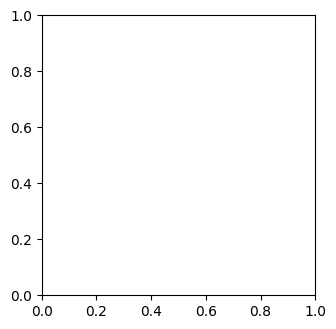

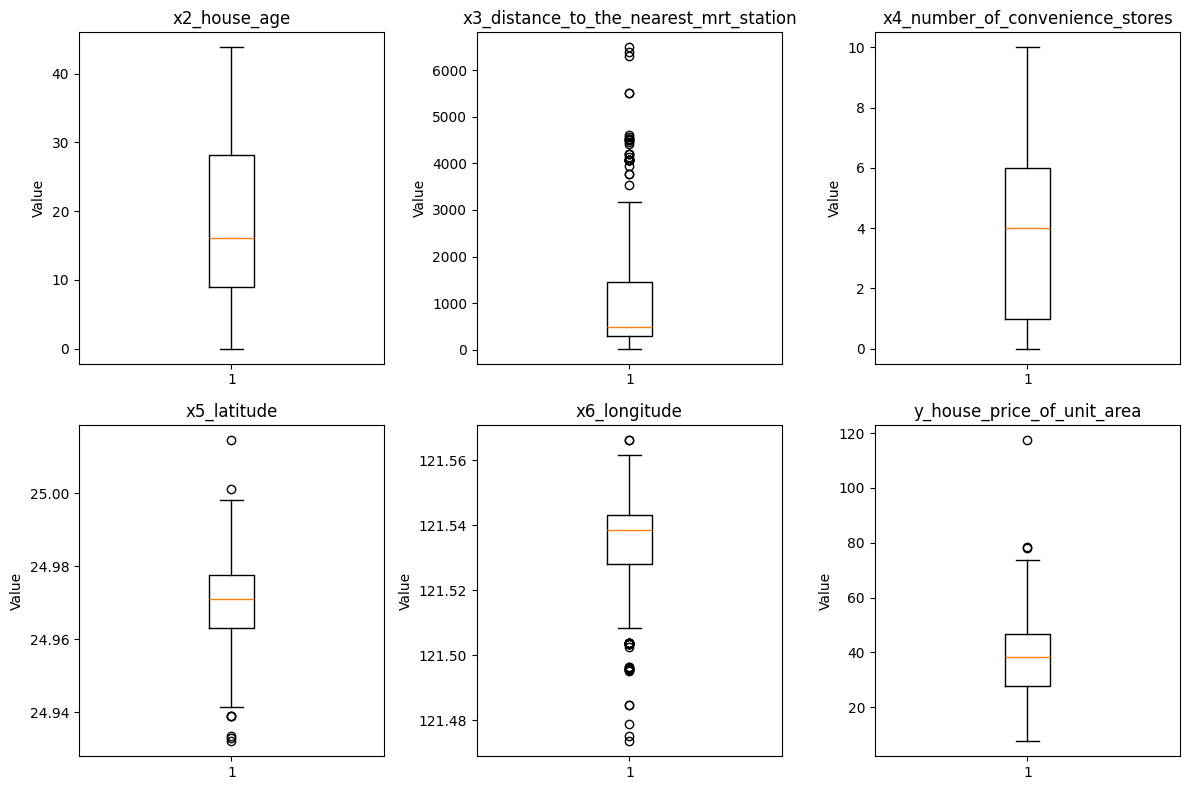

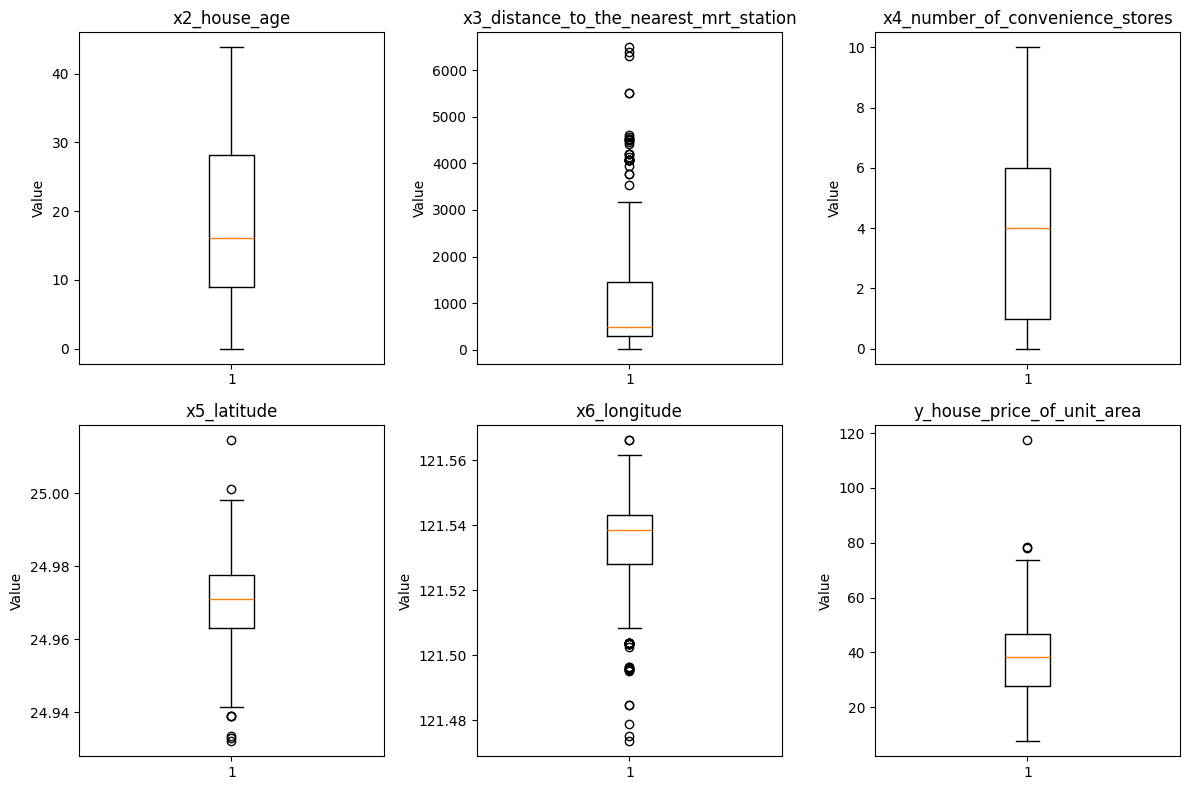

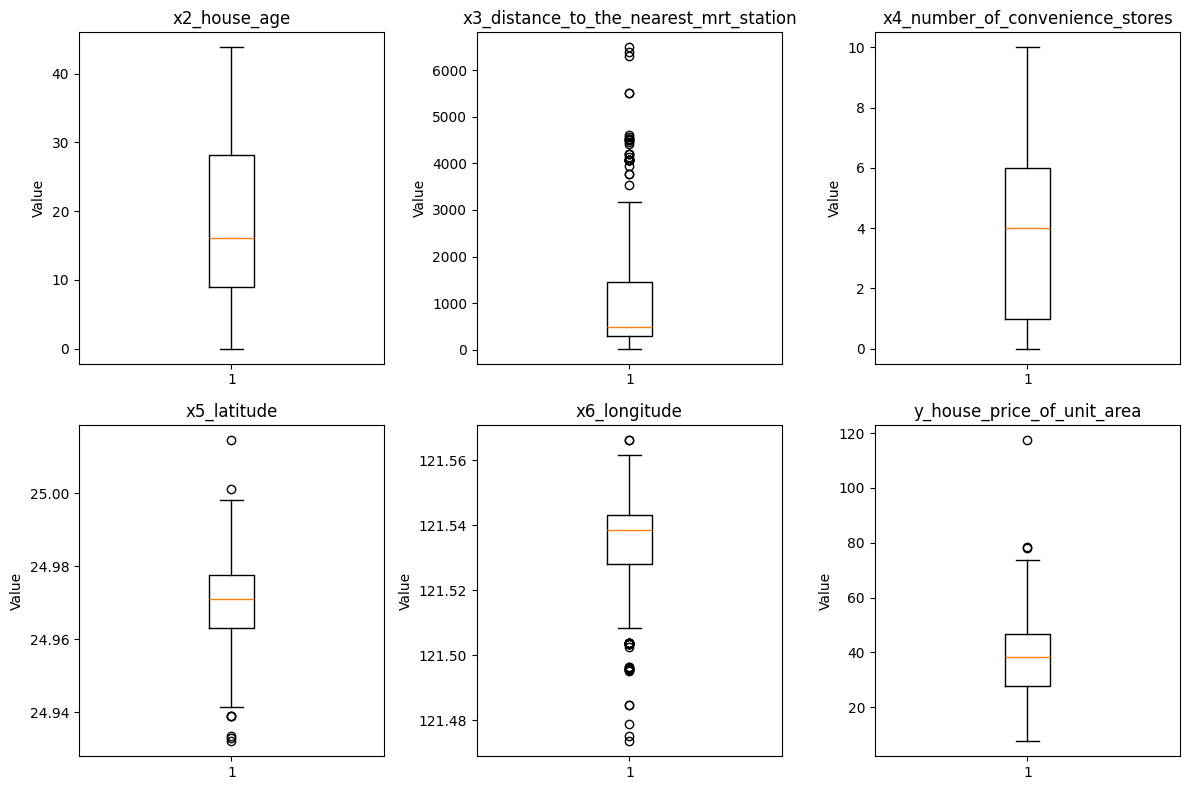

Traceback (most recent call last):
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\pipeline.py", line 137, in run
    raise e
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 113, in execute
    raise e
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 85, in execute
    result = self.execute_code(code_to_run, code_context)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

'Unfortunately, I was not able to answer your question, because of the following error:\n\nNo result returned\n'

In [17]:
# Graphical representation of outliers to confirm outlier detection for "x3_distance_to_the_nearest_mrt_station" and "y_house_price_of_unit_area" variables
#And checking for potential outliers in other variables
house_price.chat('display all outliers of dataset in boxplots')

In [18]:
#Count the outliers in each of the columns
house_price.chat('count outliers in each column')

                                        Outlier Count
transaction_id                                      0
x1_transaction_date                                 0
x2_house_age                                        0
x3_distance_to_the_nearest_mrt_station             37
x4_number_of_convenience_stores                     0
x5_latitude                                         8
x6_longitude                                       35
y_house_price_of_unit_area                          3


,Outlier Count
transaction_id,0
x1_transaction_date,0
x2_house_age,0
x3_distance_to_the_nearest_mrt_station,37
x4_number_of_convenience_stores,0
x5_latitude,8
x6_longitude,35
y_house_price_of_unit_area,3


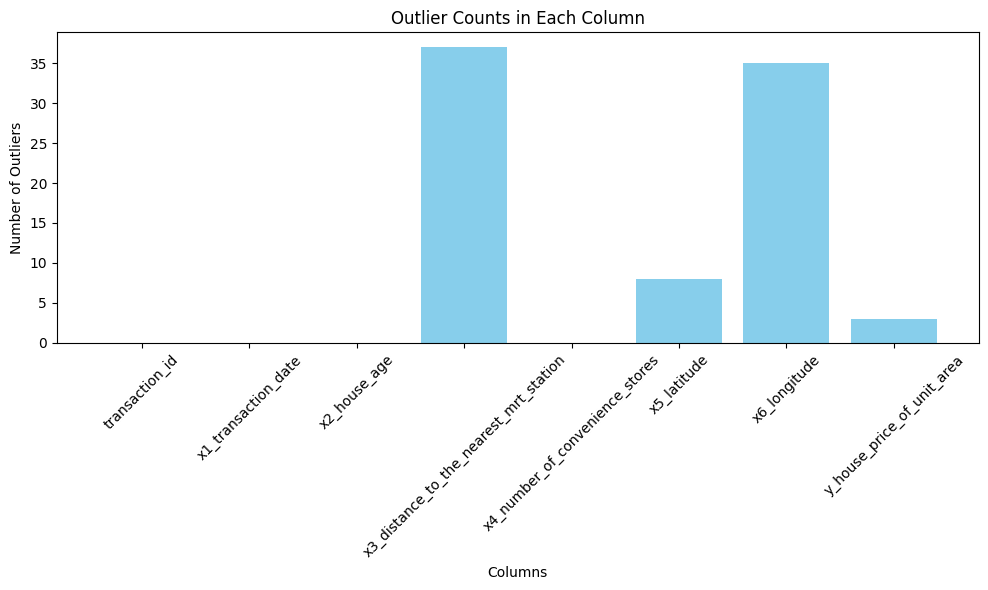

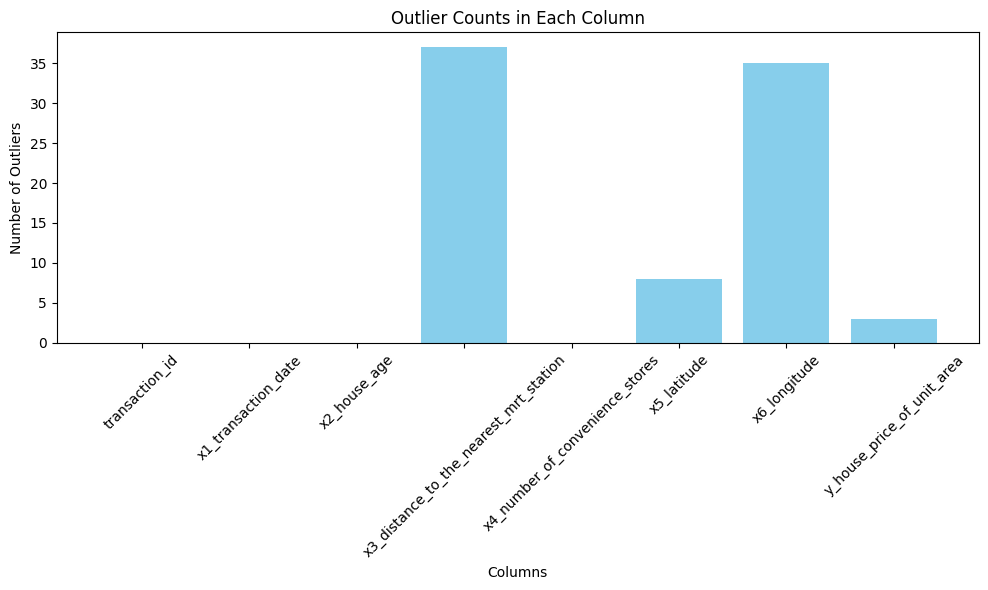

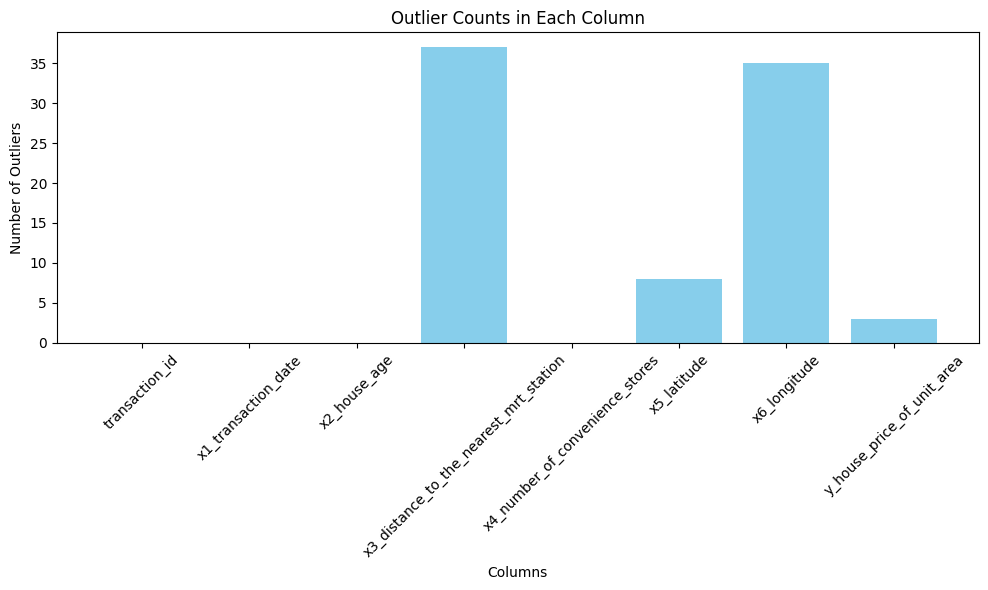

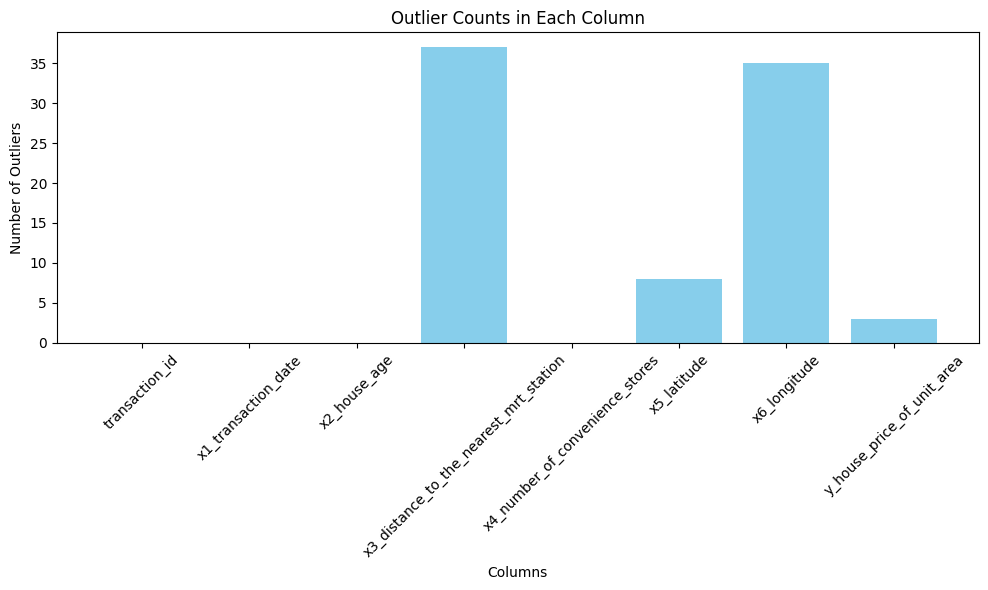

Traceback (most recent call last):
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\pipeline.py", line 137, in run
    raise e
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 113, in execute
    raise e
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 97, in execute
    raise InvalidOutputValueMismatch(
pandasai.exceptions.InvalidOutputValueMismatch: Value type <class

"Unfortunately, I was not able to answer your question, because of the following error:\n\nValue type <class 'str'> must match with type plot\n"

In [19]:
house_price.chat('count outliers in each column and show it in column bars')

In [30]:
house_price.chat('show 97th percentile of x3_distance_to_the_nearest_mrt_station column')

{'type': 'number', 'value': np.float64(4435.033050000001)}


np.float64(4435.033050000001)

In [20]:
# Replacing "x3_distance_to_the_nearest_mrt_station" outliers with 97th percentile.
house_price.chat('replace outliers in "x3_distance_to_the_nearest_mrt_station" column with 97th percentile')

,transaction_id,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4435.03305,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


In [31]:
house_price.chat('replace outliers in "x3_distance_to_the_nearest_mrt_station" column with 4435.033050000001')

,transaction_id,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4435.03305,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


,transaction_id,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
220,221,2013.333,37.2,186.5101,9,24.97703,121.54265,78.3
270,271,2013.333,10.8,252.5822,1,24.97460,121.53046,117.5
312,313,2013.583,35.4,318.5292,9,24.97071,121.54069,78.0


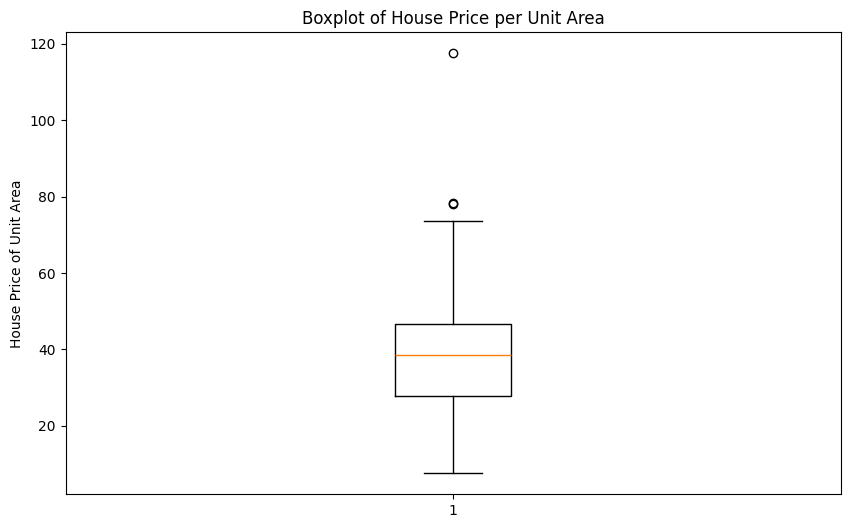

In [38]:
#Remove records with outliers in 'y_house_price_of_unit_area' column
house_price.chat('what are the outliers of the y_house_price_of_unit_area column')

In [46]:
# Removing 3 outliers from the "y_house_price_of_unit_area" column.
# We can see that number of rows reduced to 411.
house_price.chat('remove 3 outliers from the "y_house_price_of_unit_area" ')

,transaction_id,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4435.03305,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


# Data Analysis for Data Understanding

,transaction_id,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1084.770348,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1247.018677,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,4435.033050,10.000000,25.014590,121.566270,117.500000


<Figure size 1000x600 with 0 Axes>

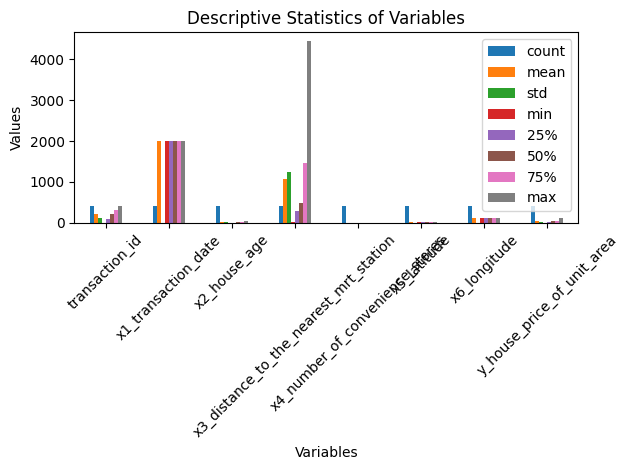

In [47]:
# Display descriptive statistics of the variables
house_price.chat('Display descriptive statistics of the variables')

In [53]:
house_price.chat('In boxplot calculate count, mean, std, min, 25% quartile, 50% quartile, 75% quartile and max values of the y_house_price_of_unit_area')

,Count,Mean,Std,Min,25%,50%,75%,Max
0,414.0,37.980193,13.606488,7.6,27.7,38.45,46.6,117.5


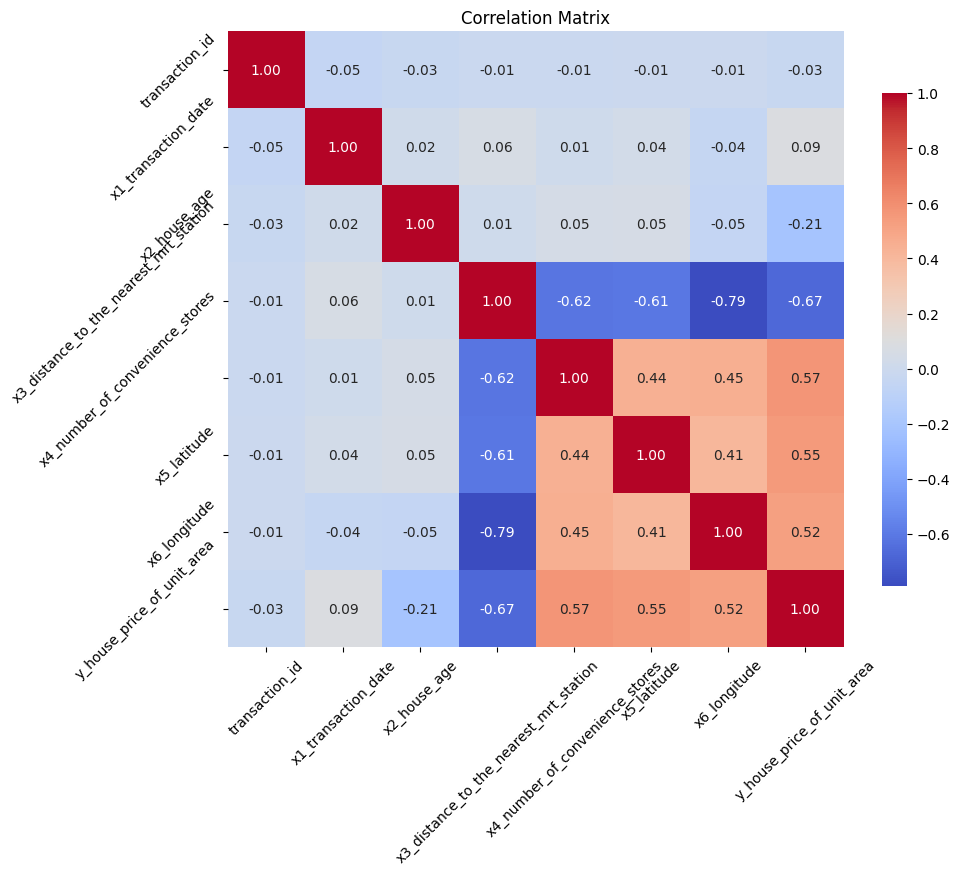

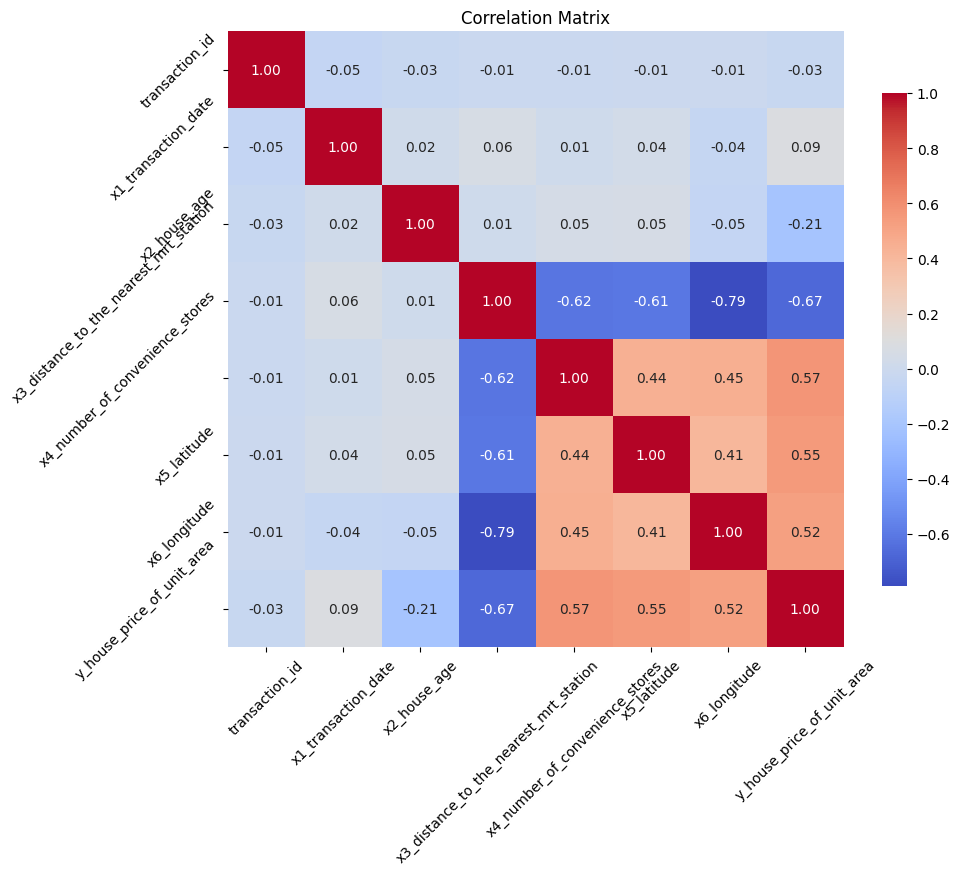

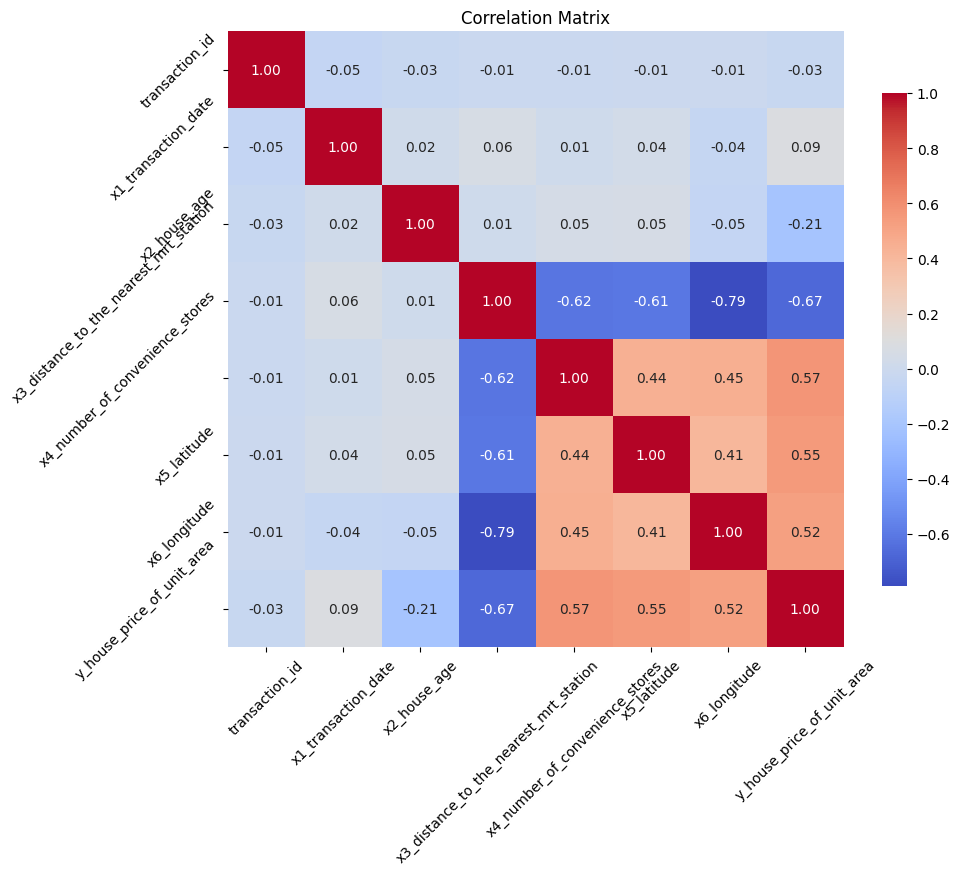

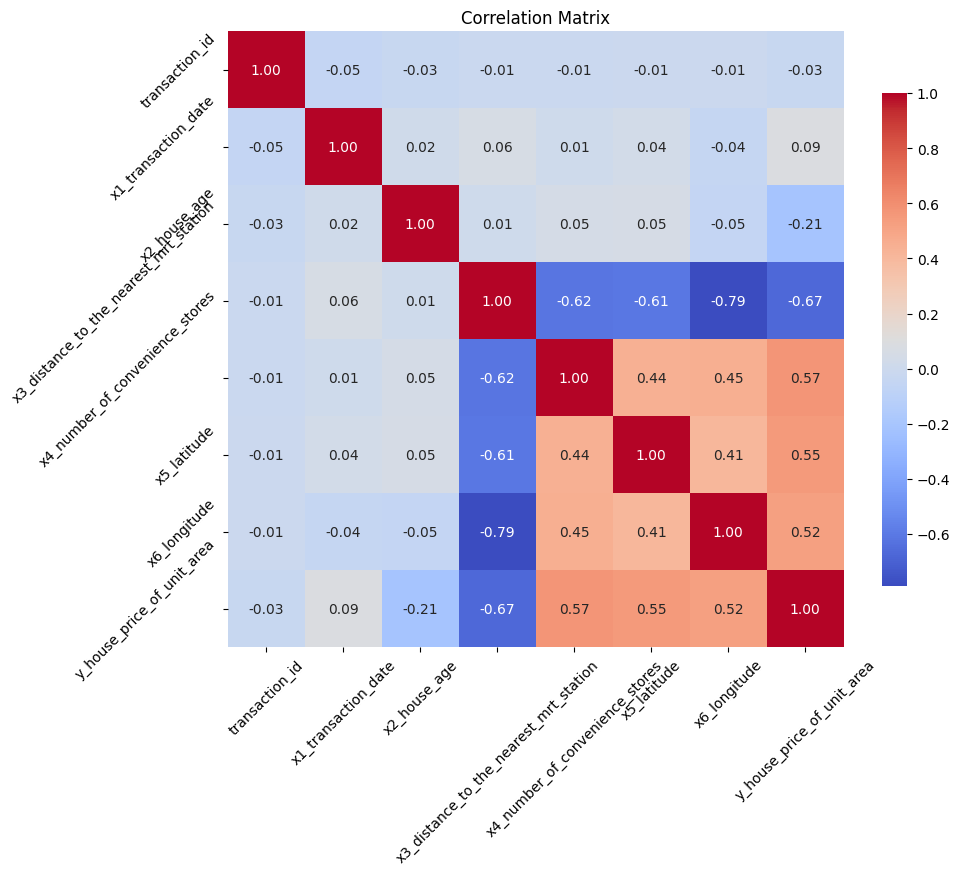

Traceback (most recent call last):
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\pipeline.py", line 137, in run
    raise e
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 113, in execute
    raise e
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 85, in execute
    result = self.execute_code(code_to_run, code_context)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

'Unfortunately, I was not able to answer your question, because of the following error:\n\nNo result returned\n'

In [54]:
# Generating and plotting the correlation matrix
house_price.chat('Generate and plot the correlation matrix')

In [56]:
house_price.chat('is the a correlation amoung the variables?')

'There is a significant correlation among the variables.'

,transaction_id,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
transaction_id,1.000000,-0.048658,-0.032808,-0.013341,-0.012699,-0.010110,-0.011059,-0.028587
x1_transaction_date,-0.048658,1.000000,0.017549,0.060272,0.009635,0.035058,-0.041082,0.087491
x2_house_age,-0.032808,0.017549,1.000000,0.013843,0.049593,0.054420,-0.048520,-0.210567
x3_distance_to_the_nearest_mrt_station,-0.013341,0.060272,0.013843,1.000000,-0.615986,-0.611656,-0.787737,-0.673104
x4_number_of_convenience_stores,-0.012699,0.009635,0.049593,-0.615986,1.000000,0.444143,0.449099,0.571005
x5_latitude,-0.010110,0.035058,0.054420,-0.611656,0.444143,1.000000,0.412924,0.546307
x6_longitude,-0.011059,-0.041082,-0.048520,-0.787737,0.449099,0.412924,1.000000,0.523287
y_house_price_of_unit_area,-0.028587,0.087491,-0.210567,-0.673104,0.571005,0.546307,0.523287,1.000000


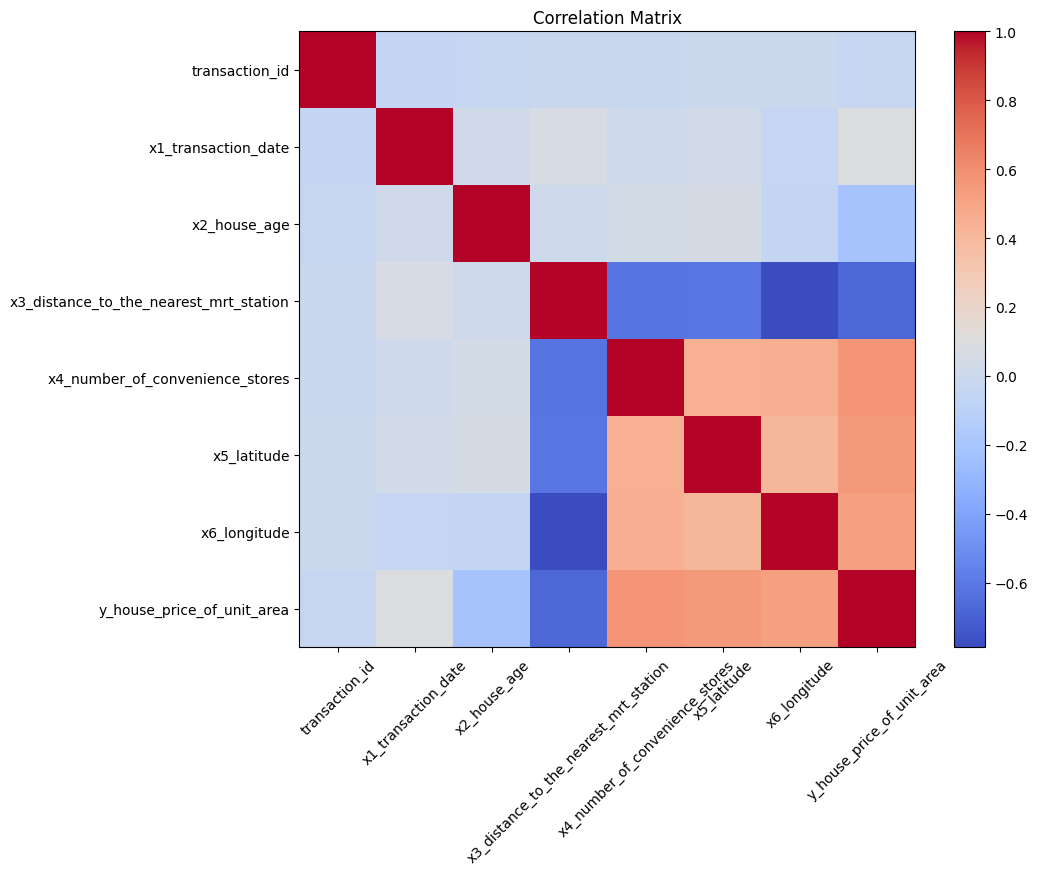

In [57]:
house_price.chat('show this correlation in a table')

# 3 - Decision Tree Regression Model

# Defining best predictors and Target

In [61]:
# Finding predictors amoung our variables.
house_price.chat('display the best predictors for the house price of unit area')

Index(['transaction_id', 'x1_transaction_date', 'x2_house_age',
       'x3_distance_to_the_nearest_mrt_station',
       'x4_number_of_convenience_stores', 'x5_latitude', 'x6_longitude',
       'y_house_price_of_unit_area'],
      dtype='object')


,y_house_price_of_unit_area
y_house_price_of_unit_area,1.000000
x4_number_of_convenience_stores,0.571005
x5_latitude,0.546307
x6_longitude,0.523287
x1_transaction_date,0.087491
transaction_id,-0.028587
x2_house_age,-0.210567
x3_distance_to_the_nearest_mrt_station,-0.673104


,Predictor,Correlation with House Price
0,x3_distance_to_the_nearest_mrt_station,-0.673104
1,x4_number_of_convenience_stores,0.571005
2,x5_latitude,0.546307
3,x6_longitude,0.523287


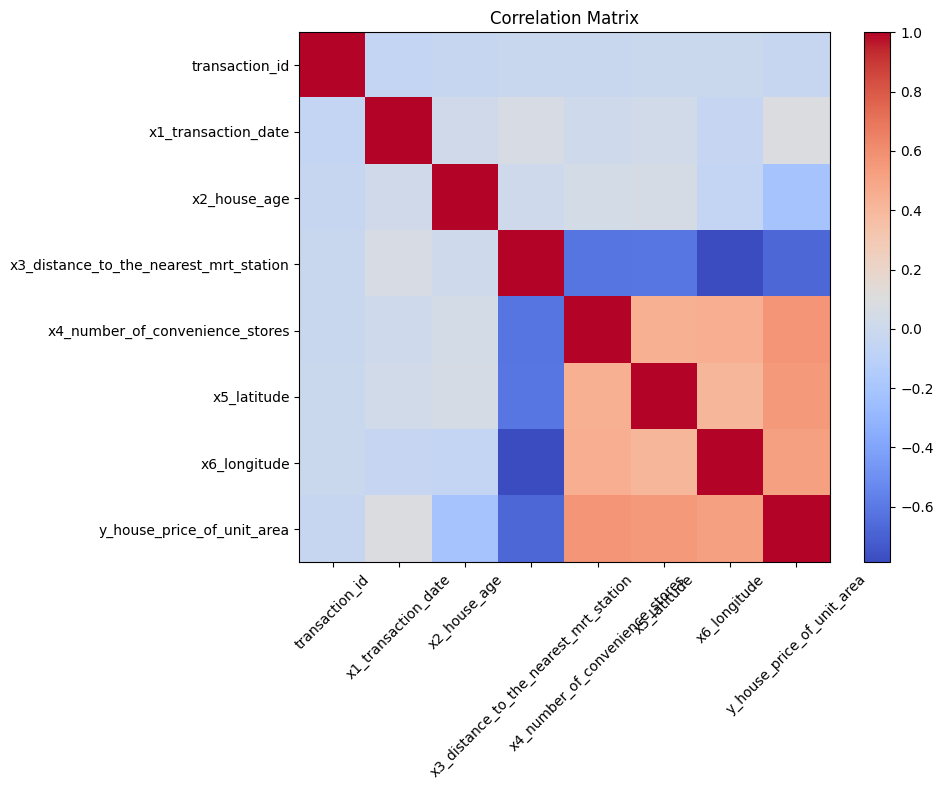

In [68]:
# Defining the best predictors for the model.
house_price.chat('which of them are the best predictors fot the house_price_of_unit_area')

In [69]:
# Puting x3_distance_to_the_nearest_mrt_station, x4_number_of_convenience_stores, x5_latitude, x6_longitude  under the name Best Predistors.
house_price.chat('define them as a best predictors')

'The best predictors for house price of unit area are: X2 house age, X3 distance to the nearest MRT station, X4 number of convenience stores, X5 latitude, X6 longitude.'

In [90]:
house_price.chat('show valuse of "y house price of unit area" column')

Traceback (most recent call last):
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7096, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Y house price of unit area'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  F

"Unfortunately, I was not able to answer your question, because of the following error:\n\n'Y house price of unit area'\n"

In [ ]:
# In my previous attempts pandasai displayed me an column of house_price_of_unit_area with 414 rows, ignoring all steps of data cleaning.

In [80]:
# Putting House price of unit area under the name Target
#  !!!  Pandasai displays y_hous_price_of_unit_area as it was before removing outliers from this column.
house_price.chat('define this column as a Target')

"The target column is defined as 'Y house price of unit area'."

# Spliting dataset into training and validation dataset.

In [ ]:
house_price.chat('crate new dataframe from target and best predictors')

In [118]:
house_price.chat('split target and best predictors into training and validation dataset where validation dataset size i 40%')

Index(['transaction_id', 'x1_transaction_date', 'x2_house_age',
       'x3_distance_to_the_nearest_mrt_station',
       'x4_number_of_convenience_stores', 'x5_latitude', 'x6_longitude',
       'y_house_price_of_unit_area'],
      dtype='object')


Traceback (most recent call last):
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\pipeline.py", line 137, in run
    raise e
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 113, in execute
    raise e
  File "C:\Users\ÖRNEK AİLESİ\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandasai\pipelines\chat\code_execution.py", line 85, in execute
    result = self.execute_code(code_to_run, code_context)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

'Unfortunately, I was not able to answer your question, because of the following error:\n\n"None of [Index([\'X2 house age\', \'X3 distance to the nearest MRT station\',\\n       \'X4 number of convenience stores\', \'X5 latitude\', \'X6 longitude\'],\\n      dtype=\'object\')] are in the [columns]"\n'